#### Импорт библиотек

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

#### Классы для производной

In [2]:
class DerivativeNum:
    
    def __init__(self, function=None, h=None, alpha=1, dots=0):
        self._n = 0
        self._function = function
        self._h = h
        self.SetAlpha(alpha)
        self.SetDots(dots)

    def SetAlpha(self, alpha):
        self._alpha = alpha
        self._alphaN = alpha
        
    def SetDots(self, dots):
        self._dots = dots
        self._dotsN = dots
    
    def Calculate(self, x):
        return np.dot(self._alphaN, self._function(x+self._h*self._dotsN))/(self._h**self._n)

    def __call__(self, x):
        return self.Calculate(x)

In [3]:
class DerivativeNum4(DerivativeNum):
    def __init__(self, function=None, h=None):
        super().__init__(function, h, np.array([0.5, -0.5]), np.array([1., -1.]))
        self._n = 1

#### Уравнение Ферхюльста

In [4]:
class LogisticRightHandSide:
    
    def __init__(self, alpha=0.2, R=100):
        self.SetAlpha(alpha)
        self.SetR(R)
        
    def SetAlpha(self, alpha):
        self._alpha = float(alpha)
        
    def SetR(self, R):
        self._R = float(R)
    
    def __call__(self, u):
        return self._alpha*u*(1. - u/self._R)

#### Решение уравнения Ферхюльста

In [5]:
class LogisticSolution:
    
    def __init__(self, alpha=0.2, R=100, U0=2):
        self.SetAlpha(alpha)
        self.SetR(R)
        self.SetU0(U0)
        
    def SetAlpha(self, alpha):
        self._alpha = float(alpha)
        
    def SetR(self, R):
        self._R = float(R)
    
    def SetU0(self, U0):
        self._U0 = float(U0)
    
    def __call__(self, t):
        k, p0, r = self._R, self._U0, self._alpha
        return k*p0*np.exp(r*t)/(k + p0 * (np.exp(r*t)-1))

#### Класс для решения нелинейного уравнения

In [6]:
class NewtonMethodSolver(DerivativeNum4):
    def __init__(self):
        super().__init__()
        self._h =1e-3
        self._function = self.NewtonMethodFunction
        self._nonlinearSolverTolerance = 1e-3
        self._maxIterations = 10
    
    def NewtonMethodFunction(self, y):
        return y - self._dt/2.*self._rightHandSideFunction(y) \
                - self._solutionArray[self._counter] \
                - self._dt/2.*self._rightHandSideFunction(self._solutionArray[self._counter])
    
    def UStarValue(self, uOld):
        self._NewtonCounter = 0
        Error = 1.
        while Error > self._nonlinearSolverTolerance :
            uNew = uOld - self._function(uOld)/self.Calculate(uOld)
            self._NewtonCounter += 1
            if self._NewtonCounter >= self._maxIterations:
                print('Newtons method failed to converge at %d iterations.' % (self._NewtonCounter))
                input()
            Error = np.fabs(uOld - uNew)
            uOld = uNew
        return uNew

#### Родительский класс для солверов

In [7]:
class DAESolver:
    def __init__(self):
        super().__init__()
        print('A %s solver initialized.' % self.__class__.__name__)
    
    def SetRightHandSide(self, function):
        self._rightHandSideFunction = function
    
    def SetInitialCondition(self, value):
        self._initialValue = value

    def SetGrid(self, numBlocks, tStart, tEnd):
        self._numBlocks, self._numPoints = numBlocks, numBlocks + 1
        self._tStart, self._tEnd = tStart, tEnd
        self._dt = float(self._tEnd)/float(self._numBlocks)
        self._solutionArray = np.zeros(self._numPoints)
        self._timeArray = np.linspace(self._tStart, self._tEnd, self._numPoints)

    @property
    def _Print(self):
        #print('Step #%d completed.' % (self._counter))
        pass
    
    @property
    def Solve(self):
        print('Start of timestepping via %s method...' % self.__class__.__name__)
        start = time.perf_counter()
        self._solutionArray[0] = self._initialValue
        self.TimeStepping
        end = float(time.perf_counter() - start)
        print('Timestepping complete; calculations took %.2e s.' % end)
        return self._solutionArray, self._timeArray
    
    @property
    def TimeStepping(self):
        self._counter = 0
        for i in range(self._numBlocks):
            self.PredictValue
            self._counter += 1
            self._Print
        
    @property
    def PredictValue(self):
        raise NotImplementedError('Method DAESolver.PredictValue is pure virtual')

#### Реализация методов

In [8]:
class ExplicitEuler(DAESolver):
    @property
    def PredictValue(self):
        i, u, dt, f = self._counter, self._solutionArray, self._dt, self._rightHandSideFunction
        u[i + 1] = u[i] + dt*f(u[i])

In [9]:
class Heun(DAESolver):
    @property
    def PredictValue(self):
        i, u, dt, f = self._counter, self._solutionArray, self._dt, self._rightHandSideFunction
        uStar = u[i] + dt*f(u[i])
        u[i + 1] = u[i] + dt/2.*(f(u[i]) + f(uStar))

In [10]:
class RK4(DAESolver):
    @property
    def PredictValue(self):
        i, u, dt, f = self._counter, self._solutionArray, self._dt, self._rightHandSideFunction
        k1 = f(u[i])
        k2 = f(u[i] + dt/2.*k1)
        k3 = f(u[i] + dt/2.*k2)
        k4 = f(u[i] + dt*k3)
        u[i + 1] = u[i] + dt/6. * (k1 + 2.*k2 + 2.*k3 + k4)

In [11]:
class Trapezium(DAESolver, NewtonMethodSolver):
    def __init__(self):
        super().__init__()
        self._function = self.NewtonMethodFunction
    
    @property
    def _Print(self):
        #print('Step #%d completed by %d iterations' % (self._counter, self._NewtonCounter))
        pass
      
    @property
    def PredictValue(self):
        i, u, dt, f = self._counter, self._solutionArray, self._dt, self._rightHandSideFunction
        uOld = u[i] + dt*f(u[i])
        u[i+1]= self.UStarValue(uOld)

A ExplicitEuler solver initialized.
Start of timestepping via ExplicitEuler method...
Timestepping complete; calculations took 9.32e-05 s.
A Heun solver initialized.
Start of timestepping via Heun method...
Timestepping complete; calculations took 1.36e-04 s.
A RK4 solver initialized.
Start of timestepping via RK4 method...
Timestepping complete; calculations took 3.21e-04 s.
A Trapezium solver initialized.
Start of timestepping via Trapezium method...
Timestepping complete; calculations took 2.49e-03 s.


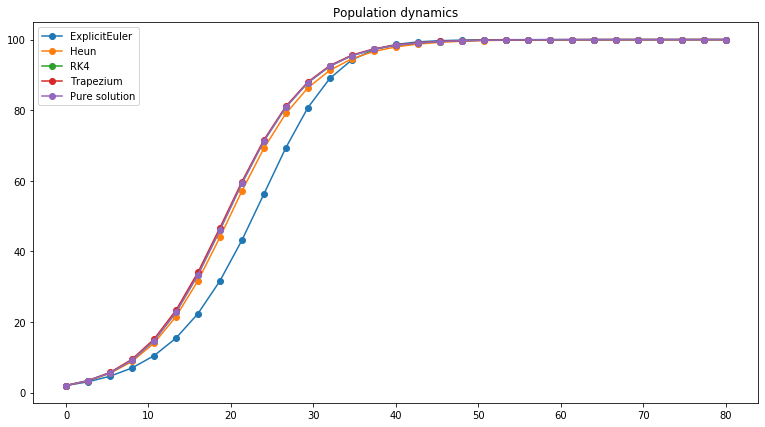

In [12]:
Rhs = LogisticRightHandSide(alpha=0.2, R=100)
sol = LogisticSolution(alpha=0.2, R=100, U0=2)
listOfMethods = [ExplicitEuler, Heun, RK4, Trapezium]
plt.figure(figsize=(13,7))
plt.title('Population dynamics')
for i, method in enumerate(listOfMethods):
    solver = method()
    solver.SetRightHandSide(Rhs)
    solver.SetInitialCondition(2)
    solver.SetGrid(numBlocks=30, tStart=0., tEnd=80.)
    SA, TA = solver.Solve
    plt.plot(TA, SA, '-o', label=solver.__class__.__name__)

arraySol = [sol(t) for t in TA]
plt.plot(TA, arraySol, '-o', label='Pure solution')
plt.legend()
plt.show()

A ExplicitEuler solver initialized.
Start of timestepping via ExplicitEuler method...
Timestepping complete; calculations took 6.99e-05 s.
A Heun solver initialized.
Start of timestepping via Heun method...
Timestepping complete; calculations took 1.31e-04 s.
A RK4 solver initialized.
Start of timestepping via RK4 method...
Timestepping complete; calculations took 1.88e-04 s.
A Trapezium solver initialized.
Start of timestepping via Trapezium method...
Timestepping complete; calculations took 2.27e-03 s.


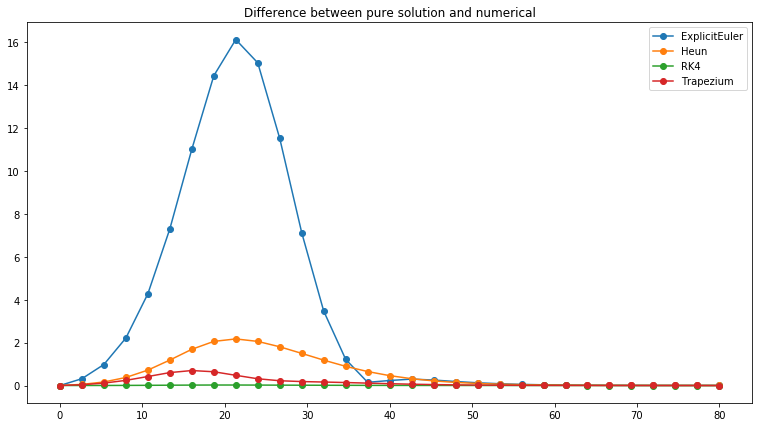

In [13]:
Rhs = LogisticRightHandSide(alpha=0.2, R=100)
sol = LogisticSolution(alpha=0.2, R=100, U0=2)
TA = np.linspace(0, 80, 31)
arraySol = [sol(t) for t in TA]

listOfMethods = [ExplicitEuler, Heun, RK4, Trapezium]
plt.figure(figsize=(13,7))
plt.title('Difference between pure solution and numerical')
for i, method in enumerate(listOfMethods):
    solver = method()
    solver.SetRightHandSide(Rhs)
    solver.SetInitialCondition(2)
    solver.SetGrid(numBlocks=30, tStart=0., tEnd=80.)
    SA, _ = solver.Solve
    plt.plot(TA, abs(SA-arraySol), '-o', label=solver.__class__.__name__)
    
plt.legend()
plt.show()